In [1]:
# !pip install numpy
# !pip install scipy
# !pip install torch
# !pip install matplotlib

In [2]:
import torch
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [3]:
# Use smaller network for testing - ex 2000 neurons
# Even for the project, doing it for 10^6 neurons would take too long
# Problem this creates: test network is denser than actual network b/c we have 10^3 neurons but 10^2 connections per neuron
num_neurons = 2000
num_i = int(0.1 * num_neurons)
num_e = int(0.9 * num_neurons)

# Num excitatory inputs and inhibitory inputs to each neuron (in reality it should be 500 but we reduce it here to make things faster)
k = 100

# Number of olfactory bulb channels (glomeruli) to each neuron
D = 10 ** 3
# For each neuron, how many glomeruli inputs it receives (should be 10^2)
num_channel_inputs = 100

# Channel signal if not active for odor a
i_0 = 2.
# Channel signal if active for odor a
i_1 = 10.
# Probability that a channel is active for an odor a
f = 0.1
# Number of odors
P = 16
# Novel activity is up to P // 2, and familiar activity is after
novel_inds = torch.arange(0, P // 2)
familiar_inds = torch.arange(P // 2, P)

In [4]:
# Creates sparse adjacency matrix with the given probability of edge connection and size mxn
def create_adj_matrix(p, m, n):
    num_connections = int(p * m * n)
    m_coords = torch.randint(0, m, (num_connections,))
    n_coords = torch.randint(0, n, (num_connections,))
    indices = torch.vstack((m_coords, n_coords))
    values = torch.ones(num_connections)
    A_mn = torch.sparse_coo_tensor(indices, values, (m, n))
    return A_mn

In [5]:
# Draws mitral activity from exponential distribution (by default the rate is 1 / f, so the mean becomes f)
# Otherwise this exponential distribution drops off too quickly
# def compute_mitral_activity(rate=1/f):
#     # Generate new sample for each odor
#     dist = torch.distributions.Exponential(rate).expand(torch.Size([D]))
#     probs = dist.sample(sample_shape=(P,))
#     probs.t_()
#     probs[probs > 1] = 1
#     I = torch.bernoulli(probs) * (i_1 - i_0) + i_0
#     return I

In [6]:
# Epsilon value defining correlation amount between odors, e < 1, e=0.5
# def correlated_mitral_activity(e):
#     # Covariance matrix representing initial correlations between odors
#     Sigma_0 = torch.ones((P, P)) * e
#     # Each odor has variance 1 (the diagonal represents variances)
#     Sigma_0.fill_diagonal_(1)
#     dist = torch.distributions.MultivariateNormal(torch.zeros(P), Sigma_0)
#     activity = dist.sample(torch.Size([D]))
#     return activity

In [7]:
# New way of generating correlations between odors: we want different sets of odors to be correlated differently, so that when we subtract each neuron's mean activity over odors, it doesn't cancel out the variation between odors (if all the odors are correlated the same, they will tend to produce similar values for a single neuron and therefore subtracting by the mean will remove these values and only leave small fluctuations)
# So we sample a small set of odors P' and make them linearly independent, and then by multiplying by a P'x P gaussian matrix we project into mitral cell activity space for all P odors, basically making the P odors a linear combination of the set of P' odors (the smaller P' is, the more correlated the resulting set of P odors will be)
# We also scale the variance depending on how small P' is, so we will maintain differently correlated odors, just with higher total correlation if P' is small

In [8]:
P_prime = 4
def correlated_mitral_activity():
    # Each of the P' odors is independent (correlation of 0)
    sigma_p_prime = torch.zeros((P_prime, P_prime)).fill_diagonal_(1)
    dist = torch.distributions.MultivariateNormal(torch.zeros(P_prime), sigma_p_prime)
    p_prime_activity = dist.sample(torch.Size([D]))
    var = 1 / P_prime
    projection = torch.normal(torch.zeros((P_prime, P)), torch.ones(P_prime, P) * np.sqrt(var))
    activity = p_prime_activity @ projection
    return activity

In [9]:
# Draws random activity with probability f
def compute_random_mitral_activity():
    I = torch.distributions.Bernoulli(f).sample(torch.Size((D, P))) * (i_1 - i_0) + i_0
    
    return I

In [10]:
# Takes in mitral activity I and computes feedforward activity h_bar_ff
def compute_feedforward_activity(I):
    # Probability that a channel weight will be nonzero
    p = num_channel_inputs / D
    # Only the first 0.9 * n rows should have this bernoulli number, the rest should be 0 b/c they don't receive a channel input
    # Check whether each neuron still receives ~10^2 nonzero inputs or what the distribution actually looks like
    # Because when we calculate the adjacency matrix we don't go by row (e.g ensuring each neuron has these ~10^2 connections)
    # Alternative: sample from Binomial distribution w/ mean 100
    # The output n for each row is the number of nonzero inputs, and you choose a random subset n of the indices for that row and make them 1
    a = create_adj_matrix(p, num_e, D)
    # Inhibitory neurons don't receive channel input
    # This is the first simplification, where we neglect the first inhibitory layer I_ff
    b = torch.zeros(size=(num_i, D)).to_sparse()
    W_ff = torch.cat(tensors=(a, b), dim=0)
    
    h_ff = (W_ff @ I) * (1 / np.sqrt(num_channel_inputs))
    h_bar_ff = h_ff - torch.mean(h_ff, dim=0, keepdim=True)
    return h_bar_ff

In [11]:
def compute_initial_recurrent_weights():
    k_ee = k_ei = k_ie = k_ii = k
    #p_ee = k_ee / num_e
    # k inhibitory inputs to that e neuron, out of num_i total inhibitory neurons gives the connection probability per neuron
    p_ei = k_ei / num_i
    p_ie = k_ie / num_e
    #p_ii = k_ii / num_i
    
    # Constants
    #w_ee = 0.1
    w_ei = 0.2
    w_ie = 0.5
    #w_ii = 0.3
    # Ignore ee and ii weights for now:
    p_ee = p_ii = w_ee = w_ii = 0
    W_ee = create_adj_matrix(p_ee, num_e, num_e) * w_ee
    W_ei = create_adj_matrix(p_ei, num_e, num_i) * -w_ei
    W_ie = create_adj_matrix(p_ie, num_i, num_e) * w_ie
    W_ii = create_adj_matrix(p_ii, num_i, num_i) * -w_ii
    
    # Concat
    W_1 = torch.cat(tensors=(W_ee, W_ei), dim=1)
    W_2 = torch.cat(tensors=(W_ie, W_ii), dim=1)
    W_rec = torch.cat(tensors=(W_1, W_2), dim=0)
    
    # For now, use dense tensor because sparse tensor has issues w/ autograd
    W_rec = W_rec.to_dense()
    
    return W_rec

In [12]:
# Computes activation threshold for neurons, based on the standard deviation of their firing rates across odors
# This average standard deviation, multiplied by theta=2, ensures that each neuron will fire for only 5% of odors
def compute_threshold(total_input, theta):
    # For now, use diff thresholds for each neuron
    center = torch.mean(total_input, dim=1, keepdim=True)
    shift = torch.std(total_input, dim=1, keepdim=True)
    threshold = center + (theta * shift)
    # Since inhibitory neurons are linear
    threshold[num_e:, :] = 0
    return threshold

In [13]:
# ReLU for excitatory, linear for inhibitory
def neuron_activations(X):
    # Mask to keep excitatory
    mask1 = torch.ones((num_neurons, 1))
    mask1[num_e:, :] = 0
    # Mask to keep inhibitory
    mask2 = torch.zeros((num_neurons, 1))
    mask2[num_e:, :] = 1
    return (torch.relu(X) * mask1) + (X * mask2)

In [14]:
# Computes R for each odor, with the activation threshold theta
def compute_piriform_response(h_bar_ff, W_rec, threshold_mult):
    # The coefficient of x_bar
    tau = 1
    # time step
    dt = 0.1
    # Number of time steps
    T = 200
    
    # Initial condition where states are gaussian
    mu_0 = 0.
    sigma_0 = 0.2
    X_0 = torch.normal(mu_0, sigma_0, size=(num_neurons, P))
    X = X_0
    
    pts = []
    for i in range(T-1):
        with torch.no_grad():
            part1 = -1 * X
            part2 = (W_rec @ neuron_activations(X)) * (1 / np.sqrt(k))
            part3 = h_bar_ff
            dXdt = (1 / tau) * (part1 + part2 + part3)
            X = X + (dXdt * dt)
        # Look at convergence pattern for first odor, assuming that it'll
        # be similar across odors (since they are all independent)
        #pts.append(torch.mean(dXdt, dim=0)[0].item())
   
    # On the last iteration only, track the gradient
    X.requires_grad_(True)
    
    part1 = -1 * X
    part2 = (W_rec @ neuron_activations(X)) * (1 / np.sqrt(k))
    part3 = h_bar_ff
    with torch.no_grad():
        # The total input to the neuron at this last time step (should be equivalent to the resulting value of X after this time step, since dxdt = 0 after the recurrent network converges)
        total_input = part2 + part3
        threshold = compute_threshold(total_input, threshold_mult)
    
    dXdt = (1 / tau) * (part1 + part2 + part3)
    X = X + (dXdt * dt)
    # Plot derivatives to see if state converged
    # plt.plot(torch.arange(T-1), pts)
    # plt.show()
    R = neuron_activations(X - threshold)
    
    return R

In [15]:
# Compute dimensionality of activity matrix R for either novel or familiar
def compute_dim(R, odor_inds):
    # Only compute for the excitatory neurons (b/c those are the ones that send signals to rest of brain
    C = torch.cov(R[:num_e, odor_inds[0]:odor_inds[-1]])
    dim = torch.trace(C) ** 2 / torch.trace(C @ C)
    return dim

# trace() is invariant for cyclic permutations of a matrix
# Since C is symmetric, it can be orthogonally diagonalized into UDU^T where U is composed of orthonormal eigenvectors, U^T = U^-1, and D is a diagonal matrix of eigenvalues
# therefore, trace(C) = trace(UDU^T) = trace(DU^TU) = trace(D) = sum(eigvals of C)
# Similarly for the denominator, we need to compute the sum of the squared eigenvalues, which is trace(D^2). trace(D^2) = trace(D^2U^TU) = trace(UD^2U^T) = trace((UDU^T)^2)) [by the property of matrix exponentiation for a diagonalizable matrix] = trace(C^2) = trace(C @ C)

In [16]:
# Dimensionalities should be similar before performing plasticity, upper bound on dimensionality is 8 b/c there are 8 odors each for novel/familiar (this is the rank of the cov matrix)
# Measures how many orthogonal directions in neuron space are needed to explain the set of odors (the max number of orthogonal directions is the number of neurons themselves)
# print(C_novel0)
# print(C_familiar0)

In [17]:
# Loop over odors and after computing R_alpha (stationary/convergence state) for each odor, perform weight update on W_rec
# Compute increment for W_rec(i,j) which is only dependent on R_alpha(i) and R_alpha(j) (two different neurons in W_rec)
# Do it only for the nonzero weights for now (because these are the only active connections between neurons)
# - Later, we could explore whether new synapses etc are created/destroyed (the changing of a weight from zero to nonzero)

In [18]:
# Set up MLP which takes in R_alpha(i) and R_alpha(j) and computes an output value delta_W_rec(i,j) which is the update value for W_rec(i,j)
# Single MLP for each class of weights (W_ee, W_ei, etc), and we adjust the weights of this MLP
# - Because plasticity is different between different kinds of neurons

In [19]:
# Start w/ small MLP - 1 hidden layer (ex. 20 units), 2 inputs, 1 output
# Each time step, we want to compute the weight update
# Compute the responses using the existing weight matrix, run thru the MLP to get the weight update, and update the weight matrix
# After n iterations, we want to calculate dimensionality (from the covariance matrix we generate from the neuron responses)
# Loss function: dim Novel / dim Familiar
# - Potential case: might make dim(Novel) as 0

# Might have to regularize the firing rate - should be close to a value we set
# Ex. could take average of neuron responses at beginning (before plasticity) and set that as target firing rate

# To prevent exploding/vanishing gradients, might have to truncate the gradient (stop it from updating after a certain iteration) because when we accumulate the gradient over the time steps to compute the response, it might blow up or just vanish
# - since the weight update is used to update the weight matrix and compute the next time step of neuron response, which in turn is fed into the MLP to compute the next weight update (very cyclical)
# Another solution - only backprop thru the last time steps of the recurrent dynamics (the time steps to compute a neuron response), b/c these are where the neuron response converges to the actual value
# Lookup how to truncate gradient PyTorch

# Instead of having plasticity act on all weights, only have plasticity between certain cell types (ex. between E and E, it will create positive feedback loop on weight update and may cause gradient blowup)
# For now, only use MLP for E -> I (minimize likelihood of gradient blowup), don't have to truncate gradient yet

In [20]:
import torch.nn as nn
import torch.optim as optim

def create_model() -> torch.nn.Sequential:
    # Number of neurons in hidden layer
    hidden_size = 100
    # Constrain output to certain values: nn.Hardtanh(-1, 1)
    model = nn.Sequential(
        nn.Linear(2, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, 1),
    )
    
    return model

In [21]:
# Start and stop indices for the section of W_rec we want to update, respectively 
# Takes in R_alpha, a vector of neuron responses to a particular odor
def compute_update(model: torch.nn.Sequential, R_alpha: torch.Tensor, update_inds) -> torch.Tensor:
    # Compute the same pairs of R_i and R_j for every odor
    # 1D vectors of the pre and postsynaptic neurons corresponding to the nonzero weights of W_rec
    postsyn_responses = R_alpha[update_inds[0]]
    presyn_responses = R_alpha[update_inds[1]]
    model_input = torch.vstack((presyn_responses, postsyn_responses)).t()
    slice_updates = model(model_input)
    
    updates = slice_updates.squeeze(dim=1)
    
    return updates

In [22]:
def odor_corrs(R):
    # We don't care about the actual responses per odor, just about a neuron's fluctuations around its mean response across odors
    R_adjusted = R - torch.mean(R, dim=1, keepdim=True)
    # Each odor becomes a variable, because we want to calculate correlations between them across neurons
    R_adjusted.t_()
    # Like cov but divides by standard deviations, effectively normalizing the values (the diagonals of the resulting matrix become 1)
    sigma_E = torch.corrcoef(R_adjusted)
    # We only care about the correlations between the familiar odors
    familiar_corrs = sigma_E[P//2:P, P//2:P] - torch.eye(P // 2)
    corr_sum = torch.sum(familiar_corrs ** 2)
    avg_corr = torch.mean(torch.abs(familiar_corrs))
    
    return corr_sum, avg_corr

In [23]:
# Sparsity per odor, across all (E) neurons
def sparsity_per_odor(R):
    sp_per_odor = 1 - ((torch.sum(R[:num_e], dim=0) ** 2) / (num_e * (torch.sum(R[:num_e] ** 2, dim=0))))
    return sp_per_odor

# Sparsity per (E) neuron, across a given odor family
def sparsity_per_neuron(R, odor_inds):
    sp_per_neuron = 1 - (
                (torch.sum(R[:num_e, odor_inds], dim=1) ** 2) / (P * torch.sum(R[:num_e, odor_inds] ** 2, dim=1)))
    return sp_per_neuron

In [24]:
# Try to minimize the correlations between values
def loss_fn(R, lambda_corr, lambda_mu, lambda_var, lambda_sp):
    corr_sum, avg_corr = odor_corrs(R)
    corr_loss = (1 / P) * corr_sum
    corr_term = lambda_corr * corr_loss
    
    means = torch.mean(R, dim=0)
    means_novel = torch.mean(means[novel_inds])
    means_familiar = torch.mean(means[familiar_inds])
    mu_term = lambda_mu * (((means_familiar - means_novel) / (means_novel + means_familiar)) ** 2)
    
    vars = torch.var(R, dim=0)
    var_novel = torch.mean(vars[novel_inds])
    var_familiar = torch.mean(vars[familiar_inds])
    var_term = lambda_var * (((var_familiar - var_novel) / (var_novel + var_familiar)) ** 2)
    
    sparsities = sparsity_per_odor(R)
    spars_novel = torch.mean(sparsities[novel_inds])
    spars_familiar = torch.mean(sparsities[familiar_inds])
    spars_term = lambda_sp * (((spars_familiar - spars_novel) / (spars_novel + spars_familiar)) ** 2)
    
    print("Avg Corr: %.4f, Corr: %.4f, Mu: %.4f, Var: %.4f, Sparsity: %.4f" % (avg_corr, corr_term, mu_term, var_term, spars_term))
    loss = corr_term + mu_term + var_term + spars_term
    return loss

In [25]:
# Detaching vs zero grad - should detach because we have a term dependent on the previous model iteration which isn't zero but some constant gradient, accumulated from that model output

In [26]:
# Upper bound for weight matrix (most weights become 10x-15x initial value if they take the naive approach of increasing inhibition)
mult = 100
w_ie = 0.5
max_weight = mult * w_ie

def loss_after_odors(model: torch.nn.Sequential, W_rec: torch.Tensor, R_current: torch.Tensor, h_bar_ff: torch.Tensor, threshold_mult, plasticity_rate, weight_decay_rate, update_inds, lambda_corr, lambda_mu, lambda_var, lambda_sp, detach_grad=True, with_loss=False):
   # First, compute the respective weight updates through the novel and familiar odors from the current neural responses (which are from the current weight matrix)
    
    #updates = W_rec[update_inds].detach().clone()
    #updates.requires_grad_(True)
    updates = torch.zeros_like(W_rec[update_inds], requires_grad=True)
    W_rec.requires_grad_(True)
   
    # Shuffle which indices we look at, so we don't always gradient clip
    # for familiar odors
    for i in torch.randperm(P):
        ou = compute_update(model, R_current[:, i], update_inds)
        # New formulation w/ weight decay
        odor_update = ou
        # At the very end, we accumulate into W_rec so we need to check whether the new W_rec value at the very end will fit within max_weight
        with torch.no_grad():
            # Regularize by the current weight in the update, so we don't add the current weight term in this expression
            val_tensor = updates + odor_update
            # E->I weights are only positive
            condition = torch.logical_and(torch.gt(val_tensor, 0.), torch.le(val_tensor, max_weight))
        
        normed_update = torch.where(condition, odor_update, 0.)
        updates = updates + normed_update
    
    updates = plasticity_rate * (updates - weight_decay_rate * W_rec[update_inds])
    
    W_rec = torch.index_put(W_rec, update_inds, updates, accumulate=True)
    
    R = compute_piriform_response(h_bar_ff, W_rec, threshold_mult)
    R_new = R
    
    if detach_grad:
        # We want a new R response tensor which only has the previous weight update but not anything before that
        W_rec = W_rec.detach()
        R_new = compute_piriform_response(h_bar_ff, W_rec, threshold_mult)

    
    if with_loss:
        loss = loss_fn(R, lambda_corr, lambda_mu, lambda_var, lambda_sp)
    else:
        loss = 0
    
    return loss, W_rec, R_new

In [27]:
# def loss_per_odor(W_rec: torch.Tensor, R_current: torch.Tensor, h_bar_ff: torch.Tensor):
#     W_rec.requires_grad_(True)
#     
#     W_rec = weight_update(W_rec, R_current, (num_e, num_neurons), (0, num_e))
#     
#     # Then find the updated neural responses from the updated weight matrix
#     R_new = compute_piriform_response(h_bar_ff, W_rec, theta)
#     
#     # Then, compute the loss, which is the ratio of the novel and familiar dimensionalities
#     loss = loss_fn(R_new)
#    
#     # We want a new R response tensor which only has the previous weight update but not anything before that
#     W_static = W_rec.detach().clone()
#     R_tosend = compute_piriform_response(h_bar_ff, W_static, theta)
#    
#     
#     return loss, W_rec, R_tosend

In [28]:
# To check theoretical minimum odor correlations, generate random gaussian matrix of shape (num_neurons, 8) and this is what the minimum correlation should be
# mu = torch.zeros((num_neurons, 16))
# std = torch.ones((num_neurons, 16))
# R_random = torch.normal(mu, std)
# loss_min = loss_fn(R_random)
# Theoretical min of 0.05

In [29]:
def verify_initial_activities():
    runs = 100
    avg_corrs = torch.empty((runs,))
    total_losses = torch.empty((runs,))
    for i in range(runs):
        with torch.no_grad():
            a = correlated_mitral_activity()
            h = compute_feedforward_activity(a)
            w = compute_initial_recurrent_weights()
            r = compute_piriform_response(h, w, 0)
        R_adjusted = r - torch.mean(r, dim=1, keepdim=True)
        R_adjusted.t_()
        sigma_E = torch.corrcoef(R_adjusted)
        familiar_corrs = sigma_E[P//2:P, P//2:P] - torch.eye(P // 2)
        total_loss = torch.sum(familiar_corrs ** 2)
        avg_corr = torch.mean(torch.abs(familiar_corrs))
        print(f"Loss: {total_loss.item()}, Avg Corr: {avg_corr}")
        total_losses[i] = total_loss
        avg_corrs[i] = avg_corr
    plt.hist(avg_corrs, bins=15)


In [30]:
# Number of independent "sniffs" of the 16 odors
n_inner = 50
# Number of different realizations of the odor sniffing process
n_outer = 100

plasticity_rate = 1e-1

# Number of inner epochs between model updates (right now we perform one update after all the inner epochs), n_update <= n_inner
n_update = 10
# Number of inner epochs across which the gradient is tracked (right now we detach the gradient after each inner epoch), n_track <= n_inner
n_track = n_update

# n_track = n_update to test formulation where we track the gradient across a subset of the inner epochs and update the model
# If n_update > n_track, the model will have multiple "gradient" paths of loss accumulated: ex. inner epochs 1-5 and a separate branch of 6-10
# If n_update < n_track, it doesn't matter b/c the model will truncate the history past its previous update since the gradient is zeroed

# Number of standard deviations from mean, we are trying 0 b/c 1 and 2 is too sparse
threshold_multiplier = 0

weight_decay = 1
# How much to weight each of the regularization terms
lambda_corr, lambda_mu, lambda_var, lambda_sp = 1, 0, 0, 0

# Try lowering plasticity across iterations
# start_rate = 1e-3
# end_rate = 1e-5
# # scale = np.log10(end_rate / start_rate)
# def plasticity_ramp(i):
#     # Linear ramp
#     slope = (end_rate - start_rate) / n_outer
#     rate = (slope * i) + start_rate
#     # Exponential ramp
#     #rate = start_rate * (10 ** ((scale * i) / epochs_outer))
#     return rate

model = create_model()

def train_model():
    
    # Model LR doesn't improve decorrelation much
    optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
    #optimizer = optim.Adam(model.parameters(), lr=1e-5)
    
    post = (num_e, num_neurons)
    pre = (0, num_e)
    
    updates_per_outer = n_inner // n_update
    num_losses = int(updates_per_outer * n_outer)
    losses = torch.empty(size=(num_losses,))
    # batch every 20 (ex. tried 50 and was slightly more noisy (but w/ similar mean))
    #batch_every = 20
    #batch_loss = 0
    for outer_e in range(n_outer):
        i = correlated_mitral_activity()
        hbar_ff = compute_feedforward_activity(i)
        # print(f"Initial feedforward dim (novel): {compute_dim(hbar_ff, novel_inds)}")
        # print(f"Initial feedforward dim (novel): {compute_dim(hbar_ff, familiar_inds)}")
        # Initial W_rec
        
        W_initial = compute_initial_recurrent_weights()
        W = W_initial.clone()
        W.requires_grad_(True)
        
        with torch.no_grad():
            weights_slice = W[post[0]:post[1], pre[0]:pre[1]]
            inds = torch.nonzero(weights_slice, as_tuple=True)
            update_inds = (inds[0] + post[0], inds[1] + pre[0])
        
        # Initial neuron responses
        R = compute_piriform_response(hbar_ff, W, threshold_multiplier)
        #plasticity_rate = plasticity_ramp(outer_e)
        
        for i in range(1, n_inner + 1):
            with_loss = False
            detach_grad = False
            if i % n_update == 0:
                with_loss = True
                print(f"Outer epoch {outer_e}, Inner epoch {i}, Loss: \t", end="")
            if i % n_track == 0:
                detach_grad = True
            loss, W, R = loss_after_odors(model, W, R, hbar_ff, threshold_multiplier, plasticity_rate, weight_decay, update_inds, lambda_corr, lambda_mu, lambda_var, lambda_sp, detach_grad=detach_grad, with_loss=with_loss)
            
            if with_loss:
                final_loss = loss
                # Don't include loss-min term
                R_initial = compute_piriform_response(hbar_ff, W_initial, threshold_multiplier)
                initial_loss = loss_fn(R_initial, lambda_corr, lambda_mu, lambda_var, lambda_sp)
                total_loss = final_loss / initial_loss
                print(f"Loss ratio: {total_loss}")
                losses[(outer_e * updates_per_outer)  + (i // n_update) - 1] = total_loss
                total_loss.backward()   
                optimizer.step()
                optimizer.zero_grad()
        
        # if outer_e % batch_every == 0:
        #     batch_loss.backward()   
        #     optimizer.step()
        #     optimizer.zero_grad()
        #     batch_loss = 0
                
    return losses

In [31]:
losses = train_model()

Outer epoch 0, Inner epoch 10, Loss: 	Avg Corr: 0.2767, Corr: 0.5049, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2767, Corr: 0.4986, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.0125625133514404
Outer epoch 0, Inner epoch 20, Loss: 	Avg Corr: 0.2797, Corr: 0.5269, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2767, Corr: 0.4986, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.0565654039382935
Outer epoch 0, Inner epoch 30, Loss: 	Avg Corr: 0.2889, Corr: 0.5609, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2767, Corr: 0.4986, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.1248244047164917
Outer epoch 0, Inner epoch 40, Loss: 	Avg Corr: 0.2976, Corr: 0.5847, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2767, Corr: 0.4986, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Loss ratio: 1.1726391315460205
Outer epoch 0, Inner epoch 50, Loss: 	Avg Corr: 0.3023, Corr: 0.5984, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2767, Co

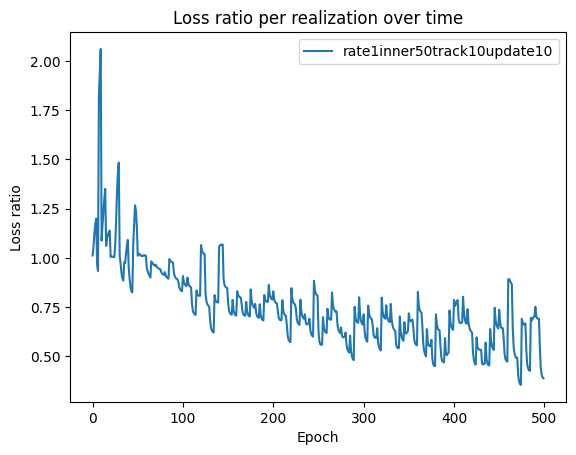

In [32]:
with torch.no_grad():
    # rate=-1, n_track=n_update=10 reduces correlations by 50%, better than rate=-2
    # Updating multiple times per epoch decreases loss below regular inner epoch formulation (if we set inner epochs = 50, only way to get it to decorrelate is to increase n_track and n_update)
    plt.plot(torch.arange(losses.shape[0]), losses)
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss ratio")
    plt.title("Loss ratio per realization over time")
    plt.show()

In [55]:
# size = 100
# hbar_dims = torch.empty((size,))
# for i in range(size):
#     i_activity = correlated_mitral_activity(e=0.9)
#     hbar_ff = compute_feedforward_activity(i_activity)
#     avg_dim = torch.mean(torch.Tensor([compute_dim(hbar_ff, novel_inds), compute_dim(hbar_ff, familiar_inds)]))
#     hbar_dims[i] = avg_dim
    
# Very low variance in feedforward input realizations
# print(torch.mean(hbar_dims).item())
# print(torch.var(hbar_dims).item())

In [56]:
i = correlated_mitral_activity()
hbar_ff = compute_feedforward_activity(i)
W_random = compute_initial_recurrent_weights()
R_random = compute_piriform_response(hbar_ff, W_random, threshold_multiplier)
E_min, E_max = torch.min(R_random[:num_e, :]), torch.max(R_random[:num_e, :])
I_min, I_max = torch.min(R_random[num_e:, :]), torch.max(R_random[num_e:, :])

In [57]:
num_ticks = 100
E_vals = torch.linspace(E_min, E_max, num_ticks)
I_vals = torch.linspace(I_min, I_max, num_ticks)
E_coords, I_coords = torch.meshgrid(E_vals, I_vals, indexing="ij")
R_plot = torch.stack((E_coords.flatten(), I_coords.flatten()), dim=1)
with torch.no_grad():
    plasticity_vals = model(R_plot)

In [58]:
# Look at how weights evolve over the course of inner epoch, for a random realization
# Store a random set of 10 weights and see how the 10 weights change over the course of the iterations

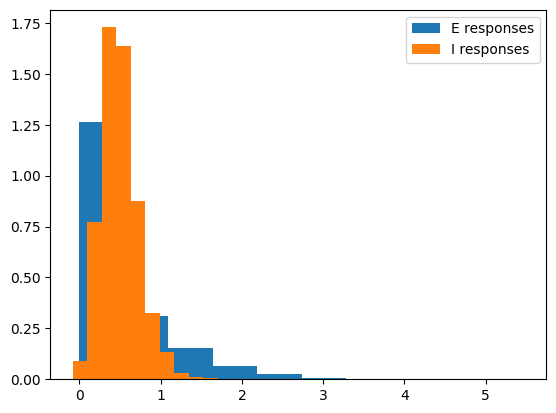

In [59]:
with torch.no_grad():
    plt.hist(torch.flatten(R_random[:num_e]), density=True, label="E responses")
    plt.hist(torch.flatten(R_random[num_e:]), density=True, label="I responses")
    plt.legend()
    plt.show()

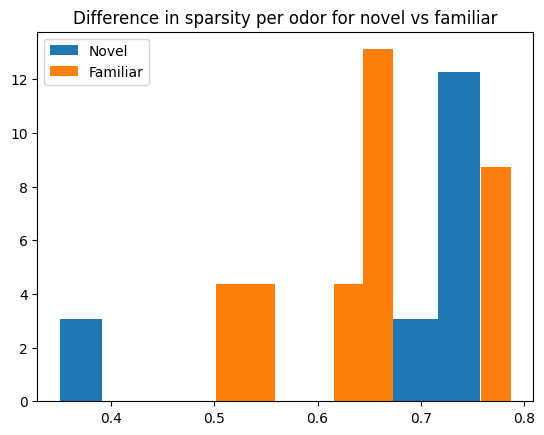

In [60]:
with torch.no_grad():
    sparsities = sparsity_per_odor(R_random)
    spars_novel = sparsities[novel_inds]
    spars_familiar = sparsities[familiar_inds]
    plt.hist(spars_novel, density=True, label="Novel")
    plt.hist(spars_familiar, density=True, label="Familiar")
    plt.title("Difference in sparsity per odor for novel vs familiar")
    plt.legend()
    plt.show()

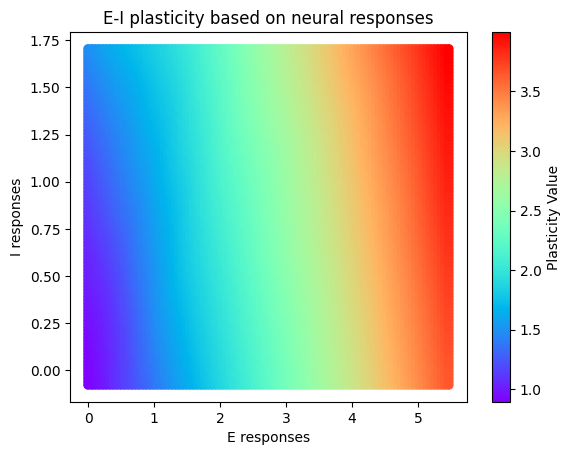

In [61]:
fig, ax = plt.subplots()
plot = plt.scatter(R_plot[:, 0], R_plot[:, 1], c=plasticity_vals.squeeze(0), cmap='rainbow')
clrbar = fig.colorbar(plot)
clrbar.set_label('Plasticity Value')
ax.set_title('E-I plasticity based on neural responses')
plt.xlabel("E responses")
plt.ylabel("I responses")
plt.show()

In [62]:
# Do a plot of rho_0 vs rho_final (for ex. 100 random initializations) to see whether the model can decorrelate odors
# Even though potentiation is always positive for the set of responses, since we are doing E to I, increasing the connection strength effectively increases inhibition too, so it balances out
# Not directly hebbian because that would mean there is some constant c*r_i*r_j, but when one of the responses is decreasing, the resulting potentiation doesn't decrease
# Instead, it will be an a * r_i + b * r_j term
# These terms come from the polynomial expansion of the function defined by the model

In [63]:
# Look at statistics of E neurons (mean firing rate across odors, variance, etc) at initialization compared to after plasticity
# Also look at sparsity - one across odors and another across neurons (sparsity is essentially 1 minus the square of the coefficient of variation)
# We care mostly about the sparsity across neurons (ex between neurons) and what it would be between odors (should be similar between the familiar odors b/c that's where we applied the plasticity) and we also know what it's like between novel odors
# We don't want a change in firing rate, because it should be same for novel and familiar odors

In [64]:
def verification_set(model, runs=10):
    corrs = torch.empty((runs,))
    ratios = torch.empty((runs,))
    for i in range(runs):
        I_ff = correlated_mitral_activity()
        hbar_ff = compute_feedforward_activity(I_ff)
        W_random = compute_initial_recurrent_weights()
        R_random = compute_piriform_response(hbar_ff, W_random, threshold_multiplier)
        _, initial_corr = odor_corrs(R_random)
        
        post = (num_e, num_neurons)
        pre = (0, num_e)
        weights_slice = W_random[post[0]:post[1], pre[0]:pre[1]]
        inds = torch.nonzero(weights_slice, as_tuple=True)
        update_inds = (inds[0] + post[0], inds[1] + pre[0])
        
        for _ in range(n_inner):
            _, W_random, R_random = loss_after_odors(model, W_random, R_random, hbar_ff, threshold_multiplier, plasticity_rate, weight_decay, update_inds, lambda_corr, lambda_mu, lambda_var, lambda_sp, detach_grad=True, with_loss=False)
        
        _, final_corr = odor_corrs(R_random)
        ratio = final_corr / initial_corr
        print(f"Corr: {initial_corr} -> {final_corr}, Ratio: {ratio}")
        corrs[i] = final_corr
        ratios[i] = ratio
        
    return corrs, ratios

Corr: 0.251024454832077 -> 0.1813046783208847, Ratio: 0.7222590446472168
Corr: 0.30929693579673767 -> 0.20014873147010803, Ratio: 0.6471086740493774
Corr: 0.3093404769897461 -> 0.19759830832481384, Ratio: 0.6387729048728943
Corr: 0.3871849477291107 -> 0.2707257866859436, Ratio: 0.6992157101631165
Corr: 0.35980284214019775 -> 0.2605527937412262, Ratio: 0.7241543531417847
Corr: 0.2608806788921356 -> 0.1784622073173523, Ratio: 0.6840760111808777
Corr: 0.29574111104011536 -> 0.2242504060268402, Ratio: 0.7582659125328064
Corr: 0.24462324380874634 -> 0.18308883905410767, Ratio: 0.748452365398407
Corr: 0.26278552412986755 -> 0.23980271816253662, Ratio: 0.9125415682792664
Corr: 0.2989509105682373 -> 0.2807851731777191, Ratio: 0.9392350316047668


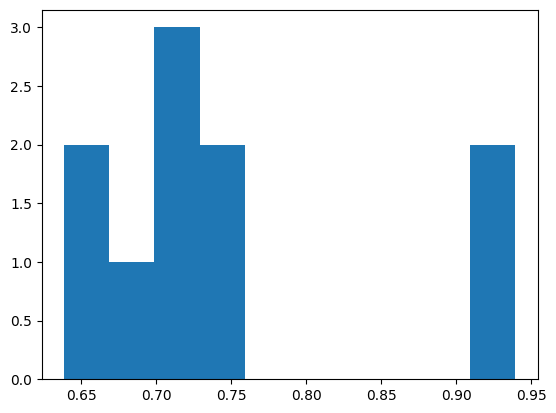

In [43]:
with torch.no_grad():
    corrs, ratios = verification_set(model, runs=10)
    plt.hist(ratios)

In [44]:
# Stats at initialization
i = correlated_mitral_activity()
hbar_ff = compute_feedforward_activity(i)
with torch.no_grad():
    W_random = compute_initial_recurrent_weights()
    R_random = compute_piriform_response(hbar_ff, W_random, threshold_multiplier)
mu_familiar_0 = torch.mean(R_random[:num_e, familiar_inds], dim=1)
sig_familiar_0 = torch.var(R_random[:num_e, familiar_inds], dim=1)
mu_novel_0 = torch.mean(R_random[:num_e, novel_inds], dim=1)
sig_novel_0 = torch.var(R_random[:num_e, novel_inds], dim=1)
#print(f"Initialization: \nFamiliar -  mean: {mu_familiar_0}, var: {sig_familiar_0}\nNovel -  mean: {mu_novel_0}, var: {sig_novel_0}")

In [45]:
# Stats after plasticity
W_plastic = W_random.detach().clone()
R_plastic = R_random.detach().clone()
post = (num_e, num_neurons)
pre = (0, num_e)
weights_slice = W_random[post[0]:post[1], pre[0]:pre[1]]
inds = torch.nonzero(weights_slice, as_tuple=True)
update_inds = (inds[0] + post[0], inds[1] + pre[0])

# Number of weights to track
num_samples = 100
W_tracked = torch.empty((n_inner, num_samples))
with torch.no_grad():
    for i in range(n_inner):
        _, W_plastic, R_plastic = loss_after_odors(model, W_plastic, R_plastic, hbar_ff, threshold_multiplier, plasticity_rate, weight_decay, update_inds, lambda_corr, lambda_mu, lambda_var, lambda_sp, detach_grad=True, with_loss=False)
        track_inds = torch.randint(0, len(update_inds), size=(num_samples,))
        W_tracked[i, :] = W_plastic[update_inds][track_inds].detach()
        
mu_familiar_f = torch.mean(R_plastic[:num_e, familiar_inds], dim=1)
sig_familiar_f = torch.var(R_plastic[:num_e, familiar_inds], dim=1)
mu_novel_f = torch.mean(R_plastic[:num_e, novel_inds], dim=1)
sig_novel_f = torch.var(R_plastic[:num_e, novel_inds], dim=1)
mu_novel_diff = mu_novel_f - mu_novel_0
mu_familiar_diff = mu_familiar_f - mu_familiar_0
sig_novel_diff = sig_novel_f - sig_novel_0
sig_familiar_diff = sig_familiar_f - sig_familiar_0

In [46]:
with torch.no_grad():
    loss_fn(R_random, lambda_corr, lambda_mu, lambda_var, lambda_sp)
    loss_fn(R_plastic, lambda_corr, lambda_mu, lambda_var, lambda_sp)

Avg Corr: 0.2932, Corr: 0.5533, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000
Avg Corr: 0.2551, Corr: 0.3996, Mu: 0.0000, Var: 0.0000, Sparsity: 0.0000


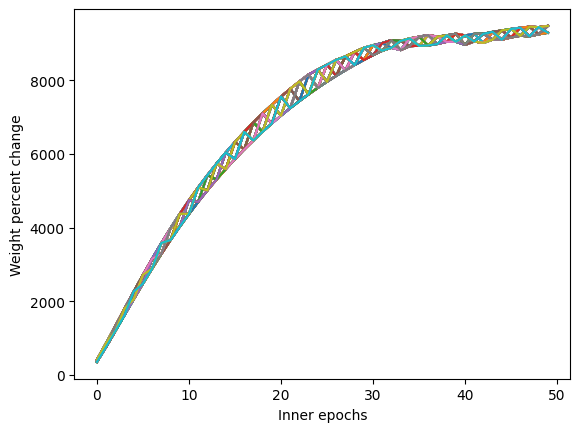

In [47]:
with torch.no_grad():
    pct_change = ((W_tracked - w_ie) / w_ie) * 100
    plt.plot(pct_change)
    plt.xlabel("Inner epochs")
    plt.ylabel("Weight percent change")

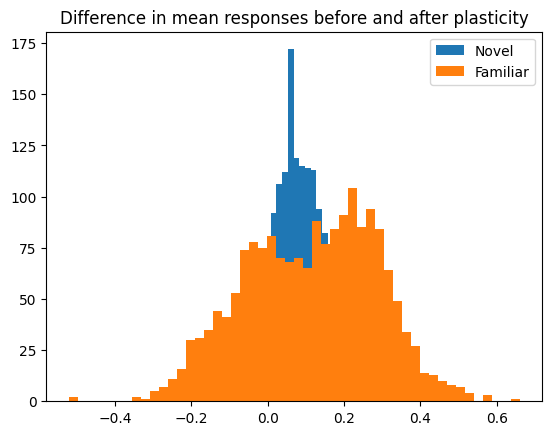

In [48]:
plt.hist(mu_novel_diff, bins=50, label="Novel")
plt.hist(mu_familiar_diff, bins=50, label="Familiar")
plt.title("Difference in mean responses before and after plasticity")
plt.legend()
plt.show()

In [49]:
weights_slice = W_random[post[0]:post[1], pre[0]:pre[1]]
inds = torch.nonzero(weights_slice, as_tuple=True)
update_inds = (inds[0] + post[0], inds[1] + pre[0])

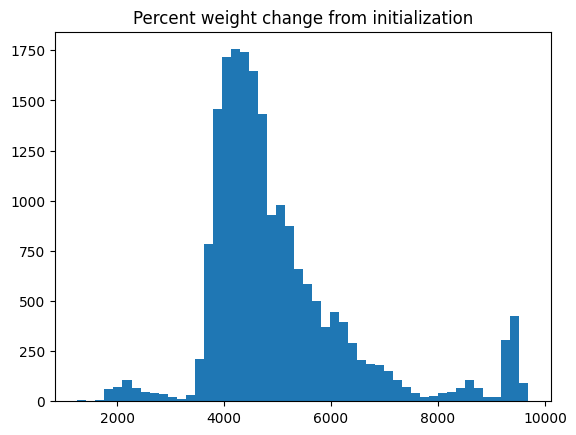

In [50]:
W_change = ((W_plastic[update_inds] - W_random[update_inds]) / W_random[update_inds]) * 100
plt.hist(W_change, bins=50)
plt.title("Percent weight change from initialization")
plt.show()
# Most weight 

In [51]:
sp_novel_0 = sparsity_per_neuron(R_random, novel_inds)
sp_novel_f = sparsity_per_neuron(R_plastic, novel_inds)
sp_familiar_0 = sparsity_per_neuron(R_random, familiar_inds)
sp_familiar_f = sparsity_per_neuron(R_plastic, familiar_inds)

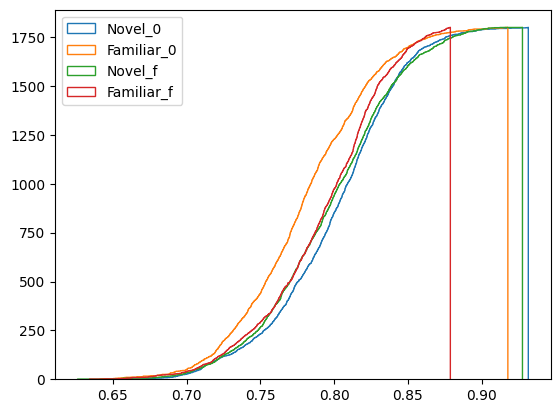

In [52]:
with torch.no_grad():
    plt.hist(sp_novel_0, cumulative=True, bins=num_e, histtype="step", label="Novel_0")
    plt.hist(sp_familiar_0, cumulative=True, bins=num_e, histtype="step", label="Familiar_0")
    plt.hist(sp_novel_f, cumulative=True, bins=num_e, histtype="step", label="Novel_f")
    plt.hist(sp_familiar_f, cumulative=True, bins=num_e, histtype="step", label="Familiar_f")
    plt.legend()
    plt.show()

In [53]:
# Create scatter plot of odor correlation vs sparsity difference - odors that are highly positively correlated should have similar sparsities across neurons, and those that are highly negatively correlated should have different sparsities across neurons
# Check - increase P' all the way to 16, and with lower correlations, there should be less variability between the sparsity for each odor
# - would tell us how much the natural spread in sparsity is

In [54]:
# 1. Re-run model w/ lower threshold (0 stdev above mean)
# 2. Figure out percentage-wise how much the weights actually change (do a hist)
# - if it's 1-2% it's too small, we want the weights to change 10-100%, the weights could even change 10-fold
# 3. Add metrics to training function - automatically compute sparsity etc (also look at the sparsity between odors, not just the sparsity between neurons, see if it changes for novel vs familiar)
# Create bar plot for each number of odors, how many neurons respond to that number of odors (ideally, if we have a threshold of 0 stdev, most neurons should respond to ~4 odors, since on average a neuron will respond to half of the total odors, so 8 odors, and out of those, it should be equal between 4 novel and 4 familiar)
# Hypothesis right now - weights aren't changing that much, so we can add more epoch_inner steps (since the gradient isn't blowing up)
# Then, try removing plasticity ramp - keep 1e-3 (don't do epoch_inner increase and remove plasticity ramp at same time)
# Goal: understand what mechanism the meta-learning discovered that makes correlations smaller (see whether it acts on sparsity etc)
# Think of other metrics to quantify network behavior to understand change